### Hawaii PBER Annotated file
I annotated this more than usual to illustrate my steps. A clean version of my code is also available and titled "AMR_HIG22_Clean"

- #TODO: Automate Vote Total Checks
- #TODO : Fix Multilevel index before JER merge
- #TODO : Change order of columns for each race to descending vote totals


### Sources
[Hawaii Election results file from MEDSL](https://github.com/MEDSL/2022-elections-official/blob/main/individual_states/2022-hi-local-precinct-general.zip), [Hawaii Precinct boundaries](https://geoportal.hawaii.gov/datasets/HiStateGIS::election-precincts/about), and [State Office of Elections Certified Report Summaries](https://elections.hawaii.gov/election-results/)

In [1]:
# load packages
import numpy as np
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_rows', None) #see all columns of dataframe

In [2]:
# Load in files
gdf = gpd.read_file('HISHP/Election_Precincts.shp')
er = pd.read_csv('HI-cleaned.csv')

In [3]:
# check both dataframes for number of unique precincts and unique precinct ID for later merging
er.precinct.nunique() # 236 
gdf.dp.nunique() # 248

248

In [4]:
# CHECK
#er.precinct.head(1) == gdf.dp.head(1)
#gdf.dp.head()
#gdf.dp.dtype

#### summary
- 12 More precincts in shapefile than in election returns data frame, will need to look into 12 'nonvoting' areas in shapefile
- unique precinct id present in same format in both dfs for later merging

### Preparing Shapefile for merging
Referenced [Metadata for shapefile](https://files.hawaii.gov/dbedt/op/gis/data/precincts.pdf)

#### summary

- Converted districts 18-05 and 42-01 from multiple geographies to multipolygons
- subset df to columns required in final merged df

In [5]:
# CHECK
#gdf.crs

In [6]:
gdf.columns

Index(['objectid', 'dp', 'dpnum', 'dptype', 'county', 'zeropop', 'ballottype',
       'us_house', 'state_hous', 'state_sena', 'county_cou', 'st_areasha',
       'st_perimet', 'geometry'],
      dtype='object')

In [7]:
# check # of zero pop precincts
gdf[['dptype']].value_counts() #239, still 3 more than er df

dptype 
VBMO       239
ZEROPOP     11
dtype: int64

In [8]:
gdf.shape # gdf has 250 rows, but 248 unique precincts

(250, 14)

In [9]:
# gdf['ballottype'].unique().size #some precincts have same ballot type, precincts smaller than county council districts

In [10]:
# look for duplicates
#gdf['objectid'].nunique() #250
gdf['dp'].nunique() #248

248

In [11]:
# filtering duplicated rows
gdf[gdf.duplicated(subset='dp', keep=False)]

,objectid,dp,dpnum,dptype,county,zeropop,ballottype,us_house,state_hous,state_sena,county_cou,st_areasha,st_perimet,geometry
246,247,42-01,4201,VBMO,OAHU,None,CD1-H42-S20-CC9,CD1,H42,S20,CC9,9.219847e+04,1370.015977,"POLYGON ((-158.03044 21.33709, -158.03090 21.3..."
247,248,42-01,4201,VBMO,OAHU,None,CD1-H42-S20-CC9,CD1,H42,S20,CC9,2.152954e+05,2002.045649,"POLYGON ((-158.02814 21.34041, -158.02829 21.3..."
248,249,18-05,1805,VBMO,OAHU,None,CD1-H18-S09-CC4,CD1,H18,S09,CC4,2.572862e+05,2852.785704,"POLYGON ((-157.71873 21.28422, -157.71864 21.2..."
249,250,18-05,1805,VBMO,OAHU,None,CD1-H18-S09-CC4,CD1,H18,S09,CC4,2.780304e+06,11075.929342,"POLYGON ((-157.70717 21.31775, -157.70638 21.3..."


noticing that for each pair, every column seems to be duplicated exactly, except columns pertaining to geometry.

<AxesSubplot:>

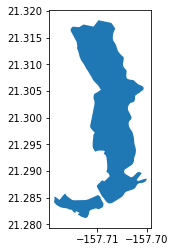

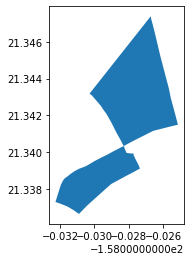

In [12]:
# look at geometries of precinct 18-05, and 42-01
gdf.iloc[[-1,-2]].plot()
gdf.iloc[[-3,-4]].plot()

For each pair, the two geometries seem to comprise one non-contiguous precinct. Looked at all four of these geometries in QGIS with OSM to confirm they are two precincts.

In [13]:
# merging 18-05,42-01 two polygons into multipolygon
gdf.geometry[len(gdf.geometry) - 2] = gdf.iloc[[-1,-2]].unary_union
gdf.geometry[len(gdf.geometry) - 4] = gdf.iloc[[-3,-4]].unary_union

In [14]:
# drop duplicate rows, check gdf
gdf.drop(labels = [247, 249], axis = 0, inplace=True)
gdf.tail(4)

,objectid,dp,dpnum,dptype,county,zeropop,ballottype,us_house,state_hous,state_sena,county_cou,st_areasha,st_perimet,geometry
244,245,51-04,5104,VBMO,OAHU,None,CD2-H51-S25-CC3,CD2,H51,S25,CC3,1.115431e+07,18414.007240,"POLYGON ((-157.70963 21.36491, -157.70948 21.3..."
245,246,51-05,5105,VBMO,OAHU,None,CD2-H51-S25-CC3,CD2,H51,S25,CC3,1.395584e+07,30871.886835,"POLYGON ((-157.75148 21.34024, -157.75128 21.3..."
246,247,42-01,4201,VBMO,OAHU,None,CD1-H42-S20-CC9,CD1,H42,S20,CC9,9.219847e+04,1370.015977,"MULTIPOLYGON (((-158.03090 21.33665, -158.0309..."
248,249,18-05,1805,VBMO,OAHU,None,CD1-H18-S09-CC4,CD1,H18,S09,CC4,2.572862e+05,2852.785704,"MULTIPOLYGON (((-157.71864 21.28445, -157.7186..."


In [15]:
# CHECK
#gdf.shape #looking for 248
#gdf.objectid.nunique()

In [16]:
#check # of populated unique precincts in shapefile
gdf['dp'].nunique() - int(gdf['zeropop'].value_counts())

237

Shapefile still has 1 more 'populated' precinct than the election returns

In [17]:
#more investigating
gdf.columns

Index(['objectid', 'dp', 'dpnum', 'dptype', 'county', 'zeropop', 'ballottype',
       'us_house', 'state_hous', 'state_sena', 'county_cou', 'st_areasha',
       'st_perimet', 'geometry'],
      dtype='object')

In [18]:
gdf.county.value_counts() #good to know for later, # of precincts in each county in this shapefile, and # and name of counties

OAHU      154
HAWAII     42
MAUI       36
KAUAI      16
Name: county, dtype: int64

In [19]:
#desperation searching for anomalous final precinct
#gdf.county_cou.nunique()
#gdf.ballottype.value_counts()

Looked at previous [PBER files on RDH github](https://github.com/nonpartisan-redistricting-datahub/pber_collection) to see column conventions

1. PRECINCT   County precinct identifier
2. SLDL_DIST  State House District
3. SLDU_DIST  State Senate District  

In [20]:
#subset gdf for merging
gdf_sub = gdf[['dp', 'county', 'us_house', 'state_hous', 'state_sena','geometry']].copy()

In [21]:
#rename columns
cols = ['PRECINCT', 'COUNTY', 'USHOUSE', 'SLDL', 'SLDU', 'geometry']
gdf_sub.columns = cols
gdf_sub.head(2)

,PRECINCT,COUNTY,USHOUSE,SLDL,SLDU,geometry
0,01-01,HAWAII,CD2,H01,S04,"POLYGON ((-155.69865 20.18589, -155.69855 20.1..."
1,01-02,HAWAII,CD2,H01,S01,"POLYGON ((-155.08329 19.85094, -155.08346 19.8..."


In [22]:
gdf_sub['SLDL'] = gdf_sub['SLDL'].apply(lambda x: str(x)[1:])
gdf_sub['SLDU'] = gdf_sub['SLDU'].apply(lambda x: str(x)[1:])
gdf_sub['USHOUSE'] = gdf_sub['USHOUSE'].apply(lambda x: str(x)[2:])

In [23]:
# CHECK
gdf_sub.head(2)

,PRECINCT,COUNTY,USHOUSE,SLDL,SLDU,geometry
0,01-01,HAWAII,2,01,04,"POLYGON ((-155.69865 20.18589, -155.69855 20.1..."
1,01-02,HAWAII,2,01,01,"POLYGON ((-155.08329 19.85094, -155.08346 19.8..."


### Preparing Elections Returns for merging

#### summary

- subset to statewide offices, or offices pertaining to a state-wide governing body
- Modified to VEST naming conventions (with further modifications to ensure under 10 letter naming convention for offices with contests in districts)
- subset df to columns required in final merged df
- created df for readme key

In [24]:
#er.head()
#er.shape()
#er.isnull().sum()

In [25]:
# Checck Write In
er.writein.value_counts()

False    16552
Name: writein, dtype: int64

In [26]:
#check how many unique precincts
er['precinct'].nunique()

236

In [27]:
er.office.unique()

array(['US SENATE', 'US HOUSE', 'GOVERNOR', 'STATE SENATOR',
       'HAWAII RESIDENT TRUSTEE VACANCY', 'AT-LARGE TRUSTEE',
       "1 HAWAI'I: MEMBERSHIP FOR THE BOARD OF ETHICS",
       "2 HAWAI'I: EXPANDING THE DUTIES OF THE COUNTY AUDITOR",
       "3 HAWAI'I: ESTABLISHING A YOUTH COMMISSION", 'COUNCILMEMBER',
       'STATE HOUSE', 'MAYOR', 'COUNCILMEMBER (EAST MAUI)',
       'COUNCILMEMBER (WEST MAUI)',
       'COUNCILMEMBER (WAILUKU-WAIHEE-WAIKAPU)',
       'COUNCILMEMBER (KAHULUI)', 'COUNCILMEMBER (SOUTH MAUI)',
       'COUNCILMEMBER (MAKAWAO-HAIKU-PAIA)', 'COUNCILMEMBER (UPCOUNTRY)',
       'COUNCILMEMBER (LANAI)', 'COUNCILMEMBER (MOLOKAI)',
       'MAUI COMMISSION PROPOSAL 1: CREATE A SEPARATE HOUSING DEPARTMENT DEDICATED TO AFFORDABLE HOUSING; INCLUDING AN ADVISORY BOARD AND HAWAIIAN HOME LANDS LIAISON',
       "MAUI COMMISSION PROPOSAL 2: DEPARTMENT OF 'OIWI RESOURCES",
       'MAUI COMMISSION PROPOSAL 3: ETHICS AND FINANCIAL DISCLOSURES',
       'MAUI COMMISSION PROPOSAL 4: PL

Checked [Ballotpedia](https://ballotpedia.org/Hawaii_state_executive_official_elections,_2022) for statewide races, and races pertaining to a state-wide governing body. There are 7 types of offices that fit this criteria.

    - US Senate
    - US House
    - Governor/Lt Gov
    - State Senator
    - State House
    - Office of Hawaiian Affairs At Large Trustee
    - Office of Hawaiian Affairs Resident Trustee

    - charter questions are COUNTY wide
    - councilmembers are also COUNTY wide

In [28]:
# subset df to rows pertaining to offices of interest
office_list = ['US SENATE', 'US HOUSE', 'GOVERNOR', 'STATE SENATOR', 'STATE HOUSE', 'AT-LARGE TRUSTEE', 'HAWAII RESIDENT TRUSTEE VACANCY']
er_sub = er[er['office'].isin(office_list)]

In [29]:
# CHECK, looking for 7 types of races
er_sub.office.value_counts().nunique()

7

In [30]:
er_sub.head(2)

,precinct,district,office,writein,party_detailed,party_simplified,candidate,dataverse,mode,votes,...,state_fips,state_cen,state_ic,date,jurisdiction_fips,county_name,county_fips,readme_check,magnitude,special
0,01-01,NaN,US SENATE,False,REPUBLICAN,REPUBLICAN,BOB MCDERMOTT,SENATE,MAIL IN,609,...,15,95,82,2022-11-08,15001,HAWAII,15001,False,1,False
1,01-01,NaN,US SENATE,False,ALOHA AINA PARTY,OTHER,EMMA JANE A POHLMAN,SENATE,MAIL IN,29,...,15,95,82,2022-11-08,15001,HAWAII,15001,False,1,False


In [31]:
#subset columns
er_sub = er_sub[['precinct', 'office', 'party_detailed', 'candidate', 'mode', 'votes']]

In [32]:
er_sub.head()

,precinct,office,party_detailed,candidate,mode,votes
0,01-01,US SENATE,REPUBLICAN,BOB MCDERMOTT,MAIL IN,609
1,01-01,US SENATE,ALOHA AINA PARTY,EMMA JANE A POHLMAN,MAIL IN,29
2,01-01,US SENATE,ALOHA AINA PARTY,BRIAN SCHATZ,MAIL IN,2521
3,01-01,US HOUSE,ALOHA AINA PARTY,JOE AKANA,MAIL IN,864
4,01-01,US HOUSE,LIBERTARIAN,MICHELLE ROSE TIPPENS,MAIL IN,84


Adapting VEST field naming convention, these are the office codes
##### (modified for contests with districts, to fit GIS 10 character limit)

- USS - U.S. Senate
- CD# - U.S. Congress District
- GOV - Governor/Lieutenant Governor
- SL##  - State Legislative Lower District ##
- SU##  - State Legislative Upper District ##
- ALT - Office of Hawaiian Affairs, At Large Trustee
- RTH - Office of Hawaiian Affairs, Resident Trustee for Hawaii (H - Hawaii, M - Maui, O - Oahu) **general election only occured for county of Hawaii

In [33]:
office_list = list(er_sub['office'].unique())
office_list

['US SENATE',
 'US HOUSE',
 'GOVERNOR',
 'STATE SENATOR',
 'HAWAII RESIDENT TRUSTEE VACANCY',
 'AT-LARGE TRUSTEE',
 'STATE HOUSE']

In [34]:
#rename offices
new_office_list = ['G22USS', 'G22CD', 'G22GOV', 'GSU', 'G22RTH', 'G22ALT', 'GSL']
er_sub['race'] = er_sub['office']
er_sub['race'].replace(office_list, new_office_list, inplace=True)

In [35]:
er_sub.head(2)

,precinct,office,party_detailed,candidate,mode,votes,race
0,01-01,US SENATE,REPUBLICAN,BOB MCDERMOTT,MAIL IN,609,G22USS
1,01-01,US SENATE,ALOHA AINA PARTY,EMMA JANE A POHLMAN,MAIL IN,29,G22USS


Will need State Senate, State House, and US congressional districts to complete naming convention. Will append from gdf.

In [36]:
#merge subset of gdf to append columns for districts
er_sub = pd.merge(er_sub,gdf_sub[['PRECINCT', 'USHOUSE', 'SLDL', 'SLDU']],left_on='precinct', right_on = 'PRECINCT', how= 'left', indicator = True)

In [37]:
#check indicator to see if merge was successful
er_sub._merge.value_counts()

both          9369
left_only        0
right_only       0
Name: _merge, dtype: int64

In [38]:
er_sub.head(2)

,precinct,office,party_detailed,candidate,mode,votes,race,PRECINCT,USHOUSE,SLDL,SLDU,_merge
0,01-01,US SENATE,REPUBLICAN,BOB MCDERMOTT,MAIL IN,609,G22USS,01-01,2,01,04,both
1,01-01,US SENATE,ALOHA AINA PARTY,EMMA JANE A POHLMAN,MAIL IN,29,G22USS,01-01,2,01,04,both


In [39]:
#replace 'CD#' with Congressional District
er_sub.loc[er_sub.race=='G22CD', 'race'] =  er_sub['race'] + er_sub['USHOUSE']
#replace 'SU#' with SLDU
er_sub.loc[er_sub.race=='GSU', 'race'] = er_sub['race'] + er_sub['SLDU']
#replace 'SL#' with SLDL
er_sub.loc[er_sub.race=='GSL', 'race'] = er_sub.race + er_sub['SLDL']

In [40]:
#check
er_sub.race.value_counts().nunique()

32

Before modifying party column, checking for how non-partisan or unregistered is noted

In [41]:
er_sub['party_detailed'].value_counts()

ALOHA AINA PARTY    7073
REPUBLICAN           797
GREEN                562
LIBERTARIAN          411
DEMOCRAT              55
Name: party_detailed, dtype: int64

In [42]:
er_sub['party_detailed'].isnull().sum()

471

#TODO: Double check HI state metadata for what null party column means

In [43]:
#change null to NONPARTISAN/UNREGISTERED
er_sub['party_detailed'].fillna('NONPARTISAN/UNREGISTERED', inplace = True)

In [44]:
#append 1 letter party to make VEST column
er_sub['VEST'] = er_sub['race'] + er_sub['party_detailed'].apply(lambda x : str(x)[0])
#create 3 letter party for readme
er_sub['party_detailed'] = er_sub['party_detailed'].apply(lambda x: str(x)[:3].upper())

Before modifying candidate names for README, double check for write-in candidates

In [45]:
('WRITE IN' in er_sub['candidate'].unique())

False

In [46]:
#double check visually

#er_sub['candidate'].value_counts()

In [47]:
#append 3 letter last name to 'VEST' column
er_sub['VEST'] = er_sub['VEST'] + er_sub['candidate'].apply(lambda x: str(x).split()[-1][:3])

In [48]:
#create candidate column for readme
er_sub['candidate'] = er_sub['candidate'].apply(lambda x: str(x).split()[-1] + ', ' + ' '.join(str(x).split()[:-1]))

In [49]:
#add 3 letter party
er_sub['candidate'] += ' - ' + er_sub['party_detailed']

In [50]:
er_sub.head()

,precinct,office,party_detailed,candidate,mode,votes,race,PRECINCT,USHOUSE,SLDL,SLDU,_merge,VEST
0,01-01,US SENATE,REP,"MCDERMOTT, BOB - REP",MAIL IN,609,G22USS,01-01,2,01,04,both,G22USSRMCD
1,01-01,US SENATE,ALO,"POHLMAN, EMMA JANE A - ALO",MAIL IN,29,G22USS,01-01,2,01,04,both,G22USSAPOH
2,01-01,US SENATE,ALO,"SCHATZ, BRIAN - ALO",MAIL IN,2521,G22USS,01-01,2,01,04,both,G22USSASCH
3,01-01,US HOUSE,ALO,"AKANA, JOE - ALO",MAIL IN,864,G22CD2,01-01,2,01,04,both,G22CD2AAKA
4,01-01,US HOUSE,LIB,"TIPPENS, MICHELLE ROSE - LIB",MAIL IN,84,G22CD2,01-01,2,01,04,both,G22CD2LTIP


In [51]:
#check party value_counts
er_sub['party_detailed'].value_counts()

ALO    7073
REP     797
GRE     562
NON     471
LIB     411
DEM      55
Name: party_detailed, dtype: int64

In [52]:
#drop extra columns
er_sub.drop(labels = ['PRECINCT', 'party_detailed','USHOUSE', 'SLDL', 'SLDU', '_merge'], axis = 1, inplace = True)

In [53]:
er_sub.head(2)

,precinct,office,candidate,mode,votes,race,VEST
0,01-01,US SENATE,"MCDERMOTT, BOB - REP",MAIL IN,609,G22USS,G22USSRMCD
1,01-01,US SENATE,"POHLMAN, EMMA JANE A - ALO",MAIL IN,29,G22USS,G22USSAPOH


In [54]:
#subset df for readme creation
rm = er_sub[['office', 'race', 'VEST', 'candidate']].copy().drop_duplicates(keep = 'first')

In [55]:
rm.shape #157 candidates

(157, 4)

### Pivoting Elections Return Data + Checking Vote Totals

#### summary

- 2 vote total summaries for 2 candidates for US Senate, Bonoan and Decker


In [56]:
er_pivot = er_sub.pivot_table(index = ['precinct'],
                         columns = ['office', 'race', 'candidate'],
                        values = ['votes'],
                         aggfunc = 'sum',
                              fill_value=0,
                             margins = True)#.reset_index()

In [57]:
er_pivot.shape #looking for 236

(237, 158)

In [58]:
er_pivot.tail()

votes                                 \
office              AT-LARGE TRUSTEE                                  
race                          G22ALT                                  
candidate GALUTERIA, BRICKWOOD - ALO ISA, LEI 'LEINA'ALA' AHU - ALO   
precinct                                                              
51-02                            950                            696   
51-03                            779                            619   
51-04                            550                            426   
51-05                            796                            541   
All                           139611                         120088   

                                                                              \
office                                                                         
race                                                                           
candidate KING, SAM 'KALANIKUPUA' - GRE OWENS, CHAD - NON SOUZA, KEONI - ALO   
precinct                                                                       
51-02                               826               796                972   
51-03                               598               607                765   
51-04                               284               520                677   
51-05                               403               663                968   
All                              103299            118561             135124   

                                                                               \
office                                        GOVERNOR                          
race                                            G22GOV                          
candidate WAIHEE, JOHN D - ALO AIONA, DUKE TUPAI - ALO GREEN, JOSH LUKE - ALO   
precinct                                                                        
51-02                      702                     953                   1773   
51-03                      654                     786                   1431   
51-04                      434                     586                    694   
51-05                      542                     752                    933   
All                     131033                  152237                 261025   

                                                                   ...  \
office    HAWAII RESIDENT TRUSTEE VACANCY                          ...   
race                               G22RTH                          ...   
candidate   CERMELJ, HOPE ALOHALANI - ALO TRASK, MILILANI B - ALO  ...   
precinct                                                           ...   
51-02                                 727                    1103  ...   
51-03                                 584                     880  ...   
51-04                                 334                     724  ...   
51-05                                 374                    1088  ...   
All                                107669                  176648  ...   

                                                                             \
office               US HOUSE                                                 
race                   G22CD1           G22CD2                                
candidate KRESS, CONRAD - REP AKANA, JOE - ALO TIPPENS, MICHELLE ROSE - LIB   
precinct                                                                      
51-02                       0              847                           41   
51-03                       0              681                           42   
51-04                       0              489                           30   
51-05                       0              626                           33   
All                     51217            72874                         5130   

                                                                        \
office                                     US SENATE                     
race                        

In [59]:
er_pivot.columns = er_pivot.columns.droplevel(level =0)

In [60]:
er_pivot.columns[1]

('AT-LARGE TRUSTEE', 'G22ALT', "ISA, LEI 'LEINA'ALA' AHU - ALO")

Manually check race vote totals against [State PDF Summary](https://elections.hawaii.gov/wp-content/results/histatewide.pdf)

### Break up office list but sublists of races in each office


In [61]:
for item in (office_list):
    print('****' + item + '*****')
    print(er_pivot[[(item)]].sum().astype(int).sort_index(level = 2))

****US SENATE*****
office     race    candidate                 
US SENATE  G22USS  BONOAN, FEENA M - ALO           9752
                   DECKER, DAN - ALO               4378
                   MCDERMOTT, BOB - REP          212716
                   POHLMAN, EMMA JANE A - ALO      8284
                   SCHATZ, BRIAN - ALO           581788
dtype: int32
****US HOUSE*****
office    race    candidate                   
US HOUSE  G22CD2  AKANA, JOE - ALO                145748
          G22CD1  CASE, ED - ALO                  287092
                  KRESS, CONRAD - REP             102434
          G22CD2  TIPPENS, MICHELLE ROSE - LIB     10260
                  TOKUDA, JILL N - ALO            256814
dtype: int32
****GOVERNOR*****
office    race    candidate              
GOVERNOR  G22GOV  AIONA, DUKE TUPAI - ALO    304474
                  GREEN, JOSH LUKE - ALO     522050
dtype: int32
****STATE SENATOR*****
office         race   candidate                      
STATE SENATOR  GSU23  AWA

#TODO/Anomalies
- US Senate
    - Bonoan 4876 instead of 4915
    - Bonoan needs to change to LIB
    - Decker 2189 instead of 2208
    - Pohlman to G
    - Schatz to D
- US HOUSE
    - Case to D
    - Tokuda to D
    - Akana to R
- GOV/LT GOV
    - change naming convention to be gov/ltgov
    - aionia to R
    - green to D
- STATE SENATOR
    - INOUYE to D
    - Tupai to R
    - Buenaventura to D
    - Fogel to L
    - Osborn to R
    - Richards to D
    - Tancheff to R
    - Mckelvey to D
    - Walter to R
    - Decoite to D
    - Mckay to R
    
#### TODO : Fix Party Assignments for all candidates mislabeled AA

In [62]:
#Investigate anomalies in Senate undercounts for Bonoan and Decker
bonoan = 4915-4876
print(bonoan)
decker = 2208-2189
print(decker)

39
19


Since these are small numbers, I will first check in the Mail-In votes

### Merge Precincts Shapefile

In [63]:
er_pivot.columns = er_pivot.columns.map('_'.join)

In [64]:
er_pivot.head()

,"AT-LARGE TRUSTEE_G22ALT_GALUTERIA, BRICKWOOD - ALO","AT-LARGE TRUSTEE_G22ALT_ISA, LEI 'LEINA'ALA' AHU - ALO","AT-LARGE TRUSTEE_G22ALT_KING, SAM 'KALANIKUPUA' - GRE","AT-LARGE TRUSTEE_G22ALT_OWENS, CHAD - NON","AT-LARGE TRUSTEE_G22ALT_SOUZA, KEONI - ALO","AT-LARGE TRUSTEE_G22ALT_WAIHEE, JOHN D - ALO","GOVERNOR_G22GOV_AIONA, DUKE TUPAI - ALO","GOVERNOR_G22GOV_GREEN, JOSH LUKE - ALO","HAWAII RESIDENT TRUSTEE VACANCY_G22RTH_CERMELJ, HOPE ALOHALANI - ALO","HAWAII RESIDENT TRUSTEE VACANCY_G22RTH_TRASK, MILILANI B - ALO",...,"US HOUSE_G22CD1_KRESS, CONRAD - REP","US HOUSE_G22CD2_AKANA, JOE - ALO","US HOUSE_G22CD2_TIPPENS, MICHELLE ROSE - LIB","US HOUSE_G22CD2_TOKUDA, JILL N - ALO","US SENATE_G22USS_BONOAN, FEENA M - ALO","US SENATE_G22USS_DECKER, DAN - ALO","US SENATE_G22USS_MCDERMOTT, BOB - REP","US SENATE_G22USS_POHLMAN, EMMA JANE A - ALO","US SENATE_G22USS_SCHATZ, BRIAN - ALO",All__
precinct,,,,,,,,,,,,,,,,,,,,,
01-01,1098,746,764,765,1309,1164,985,2343,816,1495,...,0,926,89,2225,0,0,665,31,2552,21054
01-02,689,559,502,544,772,810,675,1544,532,1044,...,0,597,70,1479,43,11,408,30,1699,14156
01-03,1149,813,662,805,1189,1086,1098,2243,739,1571,...,0,900,62,2265,31,19,616,32,2587,21077
01-04,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,4
02-01,1916,1268,1024,1274,1595,1845,1503,3687,1173,2347,...,0,1144,97,3797,31,28,804,64,4214,32808


In [65]:
er_pivot.columns[1]
#= gdf_sub['SLDL'].apply(lambda x: str(x)[1:])

"AT-LARGE TRUSTEE_G22ALT_ISA, LEI 'LEINA'ALA' AHU - ALO"

In [66]:
er_pivot.head()

,"AT-LARGE TRUSTEE_G22ALT_GALUTERIA, BRICKWOOD - ALO","AT-LARGE TRUSTEE_G22ALT_ISA, LEI 'LEINA'ALA' AHU - ALO","AT-LARGE TRUSTEE_G22ALT_KING, SAM 'KALANIKUPUA' - GRE","AT-LARGE TRUSTEE_G22ALT_OWENS, CHAD - NON","AT-LARGE TRUSTEE_G22ALT_SOUZA, KEONI - ALO","AT-LARGE TRUSTEE_G22ALT_WAIHEE, JOHN D - ALO","GOVERNOR_G22GOV_AIONA, DUKE TUPAI - ALO","GOVERNOR_G22GOV_GREEN, JOSH LUKE - ALO","HAWAII RESIDENT TRUSTEE VACANCY_G22RTH_CERMELJ, HOPE ALOHALANI - ALO","HAWAII RESIDENT TRUSTEE VACANCY_G22RTH_TRASK, MILILANI B - ALO",...,"US HOUSE_G22CD1_KRESS, CONRAD - REP","US HOUSE_G22CD2_AKANA, JOE - ALO","US HOUSE_G22CD2_TIPPENS, MICHELLE ROSE - LIB","US HOUSE_G22CD2_TOKUDA, JILL N - ALO","US SENATE_G22USS_BONOAN, FEENA M - ALO","US SENATE_G22USS_DECKER, DAN - ALO","US SENATE_G22USS_MCDERMOTT, BOB - REP","US SENATE_G22USS_POHLMAN, EMMA JANE A - ALO","US SENATE_G22USS_SCHATZ, BRIAN - ALO",All__
precinct,,,,,,,,,,,,,,,,,,,,,
01-01,1098,746,764,765,1309,1164,985,2343,816,1495,...,0,926,89,2225,0,0,665,31,2552,21054
01-02,689,559,502,544,772,810,675,1544,532,1044,...,0,597,70,1479,43,11,408,30,1699,14156
01-03,1149,813,662,805,1189,1086,1098,2243,739,1571,...,0,900,62,2265,31,19,616,32,2587,21077
01-04,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,4
02-01,1916,1268,1024,1274,1595,1845,1503,3687,1173,2347,...,0,1144,97,3797,31,28,804,64,4214,32808


In [112]:
#join shapefile
#jer = pd.merge(er_pivot,gdf_sub,on='PRECINCT', how= 'right', indicator = True)
#jer._merge.value_counts()

Noticing that all precincts successfully merged, including the 12 precincts that had no votes/election returns.

In [ ]:
jer.columns

### Final Checks + Export Joined Data Set

In [ ]:
#TODO Check to see if length of cols is 10 characters or less
#[i for i in jer.columns if len(i)>10]

## TESTING

In [ ]:
er_sub.head()

In [71]:
office_list

['US SENATE',
 'US HOUSE',
 'GOVERNOR',
 'STATE SENATOR',
 'HAWAII RESIDENT TRUSTEE VACANCY',
 'AT-LARGE TRUSTEE',
 'STATE HOUSE']

In [ ]:
for i in office_list:
    i

In [104]:
def get_races(office_list, df):
    for i in office_list:
        i_lst = []
        races_list = sorted(list(df[df.office == i]['race'].unique()))
        for ele in races_list:
        

In [109]:
races_list = sorted(list(er_sub[er_sub.office == 'STATE SENATOR']['race'].unique()))

In [110]:
print(races_list)

['GSU01', 'GSU02', 'GSU04', 'GSU06', 'GSU07', 'GSU08', 'GSU09', 'GSU10', 'GSU11', 'GSU12', 'GSU13', 'GSU14', 'GSU15', 'GSU16', 'GSU17', 'GSU18', 'GSU21', 'GSU22', 'GSU23', 'GSU24', 'GSU25']


In [ ]:
for ele in races_list:
    

In [86]:
print(temp)

None


In [111]:
er_pivot.head()

,"AT-LARGE TRUSTEE_G22ALT_GALUTERIA, BRICKWOOD - ALO","AT-LARGE TRUSTEE_G22ALT_ISA, LEI 'LEINA'ALA' AHU - ALO","AT-LARGE TRUSTEE_G22ALT_KING, SAM 'KALANIKUPUA' - GRE","AT-LARGE TRUSTEE_G22ALT_OWENS, CHAD - NON","AT-LARGE TRUSTEE_G22ALT_SOUZA, KEONI - ALO","AT-LARGE TRUSTEE_G22ALT_WAIHEE, JOHN D - ALO","GOVERNOR_G22GOV_AIONA, DUKE TUPAI - ALO","GOVERNOR_G22GOV_GREEN, JOSH LUKE - ALO","HAWAII RESIDENT TRUSTEE VACANCY_G22RTH_CERMELJ, HOPE ALOHALANI - ALO","HAWAII RESIDENT TRUSTEE VACANCY_G22RTH_TRASK, MILILANI B - ALO",...,"US HOUSE_G22CD1_KRESS, CONRAD - REP","US HOUSE_G22CD2_AKANA, JOE - ALO","US HOUSE_G22CD2_TIPPENS, MICHELLE ROSE - LIB","US HOUSE_G22CD2_TOKUDA, JILL N - ALO","US SENATE_G22USS_BONOAN, FEENA M - ALO","US SENATE_G22USS_DECKER, DAN - ALO","US SENATE_G22USS_MCDERMOTT, BOB - REP","US SENATE_G22USS_POHLMAN, EMMA JANE A - ALO","US SENATE_G22USS_SCHATZ, BRIAN - ALO",All__
precinct,,,,,,,,,,,,,,,,,,,,,
01-01,1098,746,764,765,1309,1164,985,2343,816,1495,...,0,926,89,2225,0,0,665,31,2552,21054
01-02,689,559,502,544,772,810,675,1544,532,1044,...,0,597,70,1479,43,11,408,30,1699,14156
01-03,1149,813,662,805,1189,1086,1098,2243,739,1571,...,0,900,62,2265,31,19,616,32,2587,21077
01-04,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,4
02-01,1916,1268,1024,1274,1595,1845,1503,3687,1173,2347,...,0,1144,97,3797,31,28,804,64,4214,32808
